In [17]:
import math
import torch
import numpy as np
from torch import nn
from tqdm import tqdm
from typing import Optional
import matplotlib.pyplot as plt
from torch.nn import functional as F

In [2]:
train_dir= '../data/mnist/train/mnist_train.csv'
test_dir= '../data/mnist/test/mnist_test.csv'

In [3]:
def read_mnist(file_name):
    mnist= []
    with open(file_name, encoding= 'utf-8') as f:
        mnist= f.readlines()
    rows= len(mnist)
    mnist= np.array([int(item) for sting in mnist for item in sting.split(',')]).reshape(rows, -1)
    return torch.from_numpy(mnist[:, 1:]).float()/ 255.0, torch.from_numpy(mnist[:, 0])

In [101]:
seed, batch_size= 1, 256
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
pics, labels= read_mnist(train_dir)
random_num= torch.rand(len(pics))
train_flag, valid_flag, test_flag= random_num< torch.tensor(0.8), (random_num>= torch.tensor(0.8))* (random_num< torch.tensor(0.9)), random_num>= torch.tensor(0.9)
train_pics, valid_pics, test_pics= pics[train_flag], pics[valid_flag], pics[test_flag]
train_labels, valid_labels, test_labels= labels[train_flag], labels[valid_flag], labels[test_flag]
train_set, valid_set, test_set= torch.utils.data.TensorDataset(train_pics, train_labels), torch.utils.data.TensorDataset(valid_pics, valid_labels), torch.utils.data.TensorDataset(test_pics, test_labels)
train_loader, valid_loader, test_loader= torch.utils.data.DataLoader(train_set, batch_size= batch_size, shuffle= True), torch.utils.data.DataLoader(valid_set, batch_size= batch_size, shuffle= True), torch.utils.data.DataLoader(test_set, batch_size= batch_size, shuffle= True)

In [5]:
class SelfAttention(nn.Module):
    def __init__(self, n_heads: torch.tensor, d_embed: torch.tensor):
        super().__init__()
        self.in_proj= nn.Linear(d_embed, 3* d_embed, bias= True)
        self.out_proj= nn.Linear(d_embed, d_embed)
        self.d_embed= d_embed
        self.n_heads= n_heads
    def forward(self, x: torch.tensor, causal_mask=False)-> torch.tensor:
        b, l, d= x.shape
        # x, (batch_size, len, dim)>> (batch_size, len, 3* dim)>> (batch_size, len, head, dim// head* 3)
        x_proj= self.in_proj(x).view(b, l, self.n_heads, -1)
        # q, k or v, (batch_size, len, head, dim// head)
        q, k, v= x_proj.chunk(3, dim= -1)
        # att, (batch_size, len, len, head)
        att= torch.einsum('blhd, bmhd->blmh', q, k)/ math.sqrt(self.d_embed// self.n_heads)
        # mask
        if causal_mask:
            mask= torch.ones_like(att, dtype=torch.bool).triu(1) 
            att.masked_fill_(mask, -torch.inf)
        att= torch.softmax(att, dim= 2)
        opt= torch.einsum('blmh, blhd-> blhd', att, v).view(b, l, d)
        return self.out_proj(opt)

In [6]:
class CrossAttention(nn.Module):
    def __init__(self, n_heads: torch.tensor, d_embed: torch.tensor, d_cross: torch.tensor):
        super().__init__()
        self.q_proj= nn.Linear(d_embed, d_embed, bias= True)
        self.kv_proj= nn.Linear(d_cross, 2* d_embed, bias= True)
        self.out_proj= nn.Linear(d_embed, d_embed, bias= True)
        self.n_heads= n_heads
        self.d_embed= d_embed
    def forward(self, x: torch.tensor, y: torch.tensor)-> torch.tensor:
        b, l, d= x.shape
        # x, (batch_size, seq_len, d_embed)-> (b, l, h, d//h), y, (batch_size, seq_len, d_cross)
        q= self.q_proj(x).view(b, l, self.n_heads, -1)
        # y, (batch_size, seq_len, 2* d_embed)-> (b, l, h, 2* d// h)-> k, v, (b, l, h, d// h)
        k, v= self.kv_proj(y).view(b, y.shape[1], self.n_heads, -1).chunk(2, dim= -1)
        att= torch.softmax(torch.einsum('blhd, bmhd-> blmh', q, k)/ (self.d_embed// self.n_heads)** 0.5, dim= 2)
        return self.out_proj(torch.einsum('blmh, bmhd-> blhd', att, v).reshape(b, l, d))

In [7]:
class VAE_AttentionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.groupnorm = nn.GroupNorm(32, channels)
        self.attention = SelfAttention(1, channels)
    def forward(self, x):
        # x: (Batch_Size, Features, Height, Width)
        residue= x 
        x= self.groupnorm(x)
        n, c, h, w= x.shape
        x= x.view((n, c, h * w))
        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Height * Width, Features). Each pixel becomes a feature of size "Features", the sequence length is "Height * Width".
        x= x.transpose(-1, -2)
        x= self.attention(x)
        x= x.transpose(-1, -2)
        # (Batch_Size, Features, Height * Width) -> (Batch_Size, Features, Height, Width)
        x= x.view((n, c, h, w))
        # (Batch_Size, Features, Height, Width)
        return x+ residue 

In [8]:
class VAE_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.groupnorm_1= nn.GroupNorm(32, in_channels)
        self.conv_1= nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.groupnorm_2= nn.GroupNorm(32, out_channels)
        self.conv_2= nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        if in_channels == out_channels:
            self.residual_layer = nn.Identity()
        else:
            self.residual_layer = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)
    def forward(self, x):
        # x: (Batch_Size, In_Channels, Height, Width)
        residue= x
        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        x= self.groupnorm_1(x)
        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, In_Channels, Height, Width)
        x= F.silu(x)
        # (Batch_Size, In_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x= self.conv_1(x)
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x= self.groupnorm_2(x)
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x= F.silu(x)
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        x= self.conv_2(x)
        # (Batch_Size, Out_Channels, Height, Width) -> (Batch_Size, Out_Channels, Height, Width)
        return x+ self.residual_layer(residue)

In [9]:
class VAE_Encoder(nn.Sequential):
    def __init__(self, device= 'cuda:0'):
        super().__init__(
            # Batch_size, B; Channel, C; Height, H; Weight, W.
            # (B, 1, H, W)-> (B, 128, H, W)
            nn.Conv2d(1, 64, kernel_size= 3, padding= 1),
            VAE_ResidualBlock(64, 64),
            # (B, 128, H, W)-> (B, 128, H/ 2, W/ 2)
            nn.Conv2d(64, 64, kernel_size= 3, stride= 2),
            # up channel
            VAE_ResidualBlock(64, 64),
            # (B, 128, H/ 2, W/ 2)-> (B, 256, H/ 4, W/ 4)
            nn.Conv2d(64, 128, kernel_size= 3, stride= 2),
            VAE_AttentionBlock(128),
            VAE_ResidualBlock(128, 128),
            nn.GroupNorm(32, 128),
            nn.SiLU(),
            nn.Conv2d(128, 8, kernel_size= 3, padding= 1),
            # output, (B, 8, H/ 4, W/ 4)
            nn.Conv2d(8, 8, kernel_size= 1, padding= 0)
        )
        self.norm_dist= torch.distributions.Normal(0, 1)
        self.device= device
    def forward(self, x):
        # transform x into latent code.
        # x, (B, 1, H, W)-> (B, 8, H/ 4, W/ 4)
        for module in self:
            # confirm H/ 2
            if getattr(module, 'stride', None)== (2, 2):
                x= F.pad(x, (0, 1, 0, 1))
            x= module(x)
        # maen, (B, 4, H/ 4, W/ 4); log_var, (B, 4, H/ 4, W/ 4)
        maen, log_var= torch.chunk(x, 2, dim= 1)
        var_= torch.clamp(log_var, -30, 20).exp()
        stdev= var_** 0.5
        z= self.norm_dist.sample(maen.shape).to(self.device)* stdev+ maen
        return maen, stdev, z

In [10]:
class VAE_Decoder(nn.Sequential):
    def __init__(self):
        super().__init__(
            # (B, 4, H/ 4, W/ 4)-> (B, 256, H/ 4, W/ 4)
            nn.Conv2d(4, 128, kernel_size= 1, padding= 0),
            nn.Conv2d(128, 128, kernel_size= 3, padding= 1),
            VAE_AttentionBlock(128),
            VAE_ResidualBlock(128, 128),
            # (B, 256, H/ 4, W/ 4)-> (B, 256, H/ 2, W/ 2)
            nn.Upsample(scale_factor= 2),
            # (B, 256, H/ 2, W/ 2)-> (B, 128, H/ 2, W/ 2)
            nn.Conv2d(128, 64, kernel_size= 3, padding= 1),
            VAE_ResidualBlock(64, 64),
            # (B, 128, H/ 2, W/ 2)-> (B, 128, H, W)
            nn.Upsample(scale_factor= 2),
            nn.Conv2d(64, 64, kernel_size= 3, padding= 1),
            VAE_ResidualBlock(64, 64),
            nn.GroupNorm(32, 64),
            nn.SiLU(),
            nn.Conv2d(64, 1, kernel_size= 3, padding= 1)
        )
    def forward(self, x):
        for module in self:
            x= module(x)
        return x

In [11]:
class VAE(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.device= device
        self.encoder= VAE_Encoder().to(device)
        self.decoder= VAE_Decoder().to(device)
    def loss_fuc(self, pred, label, mu, sga, balance_factor= 0.05, eps= 1e-10):
        return ((pred- label)** 2).mean()+ balance_factor* (sga** 2+ mu** 2- torch.log(sga+ eps)- 0.5).mean()
    def forward(self, x):
        mu, sga, z= self.encoder(x)
        return mu, sga, self.decoder(z)

In [12]:
class Swish(nn.Module):
    def forward(self, x):
        return x* torch.sigmoid(x)

In [29]:
class DenoiseDiffusion():
    def __init__(self, eps_model: nn.Module, n_steps: int, device: torch.device):
        super().__init__()
        self.eps_model= eps_model
        self.beta= torch.linspace(0.0001, 0.02, n_steps).to(device)
        self.alpha= 1- self.beta
        self.alpha_bar= torch.cumprod(self.alpha, dim= 0)
        self.n_steps= n_steps
        self.sigma= self.beta
    
    def gather(self, const: torch.tensor, t: torch.tensor):
        # collecting elements of consts with dim= -1 according to t
        c= const.gather(dim= -1, index= t)
        return c.reshape(-1, 1, 1, 1)
    
    # compute maen and var of xt according to latent        
    def q_xt_x0(self, latent: torch.tensor, t: torch.tensor):
        # xt= sqrt(at)* latent+ sqrt(1- at)* eps
        # return sqrt(at)* latent, 1- at
        mean_= self.gather(self.alpha_bar, t)** 0.5* latent
        var_= 1- self.gather(self.alpha_bar, t)
        return mean_, var_
    
    # forward-diffusion
    def q_sample(self, latent: torch.Tensor, t: torch.Tensor, eps: Optional[torch.Tensor]= None):
        # compute xt according to latent
        if eps is None:
            eps= torch.randn_like(latent)
        mean_, var_= self.q_xt_x0(latent ,t)
        return mean_+ (var_** 0.5)* eps

    # sampling a pic
    def p_sample(self, xt: torch.tensor, t: torch.tensor):
        eps_hat= self.eps_model(xt, t)
        alpha_bar= self.gather(self.alpha_bar, t)
        alpha= self.gather(self.alpha, t)
        eps_coef= (1- alpha)/ (1- alpha_bar)** 0.5
        mean_= 1/ (alpha** 0.5)* (xt- eps_coef* eps_hat)
        var_= self.gather(self.sigma, t)
        eps= torch.randn(xt.shape, device= xt.device)
        return mean_+ (var_** 0.5)* eps

    # loss
    def loss(self, latent: torch.tensor, noise: Optional[torch.Tensor]= None):
        batch_size= latent.shape[0]
        # (batch_size, )
        t= torch.randint(0, self.n_steps, (batch_size, ), device= latent.device, dtype= torch.long)
        # noise, (B, 4, H/ 4, W/ 4)
        if noise is None:noise= torch.randn_like(latent)
        # add noise
        xt= self.q_sample(latent, t, eps= noise)
        # xt, (B, 4, H/ 4, W/ 4); t, (B, )
        eps_hat= self.eps_model(xt, t)
        return F.mse_loss(noise, eps_hat)

In [14]:
class UNet_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, d_time= 128):
        super().__init__()
        self.gn_feat= nn.GroupNorm(32, in_channels)
        self.cv_feat= nn.Conv2d(in_channels, out_channels, kernel_size= 3, padding= 1)
        self.lin_time= nn.Linear(d_time, out_channels)
        self.gn_merged= nn.GroupNorm(32, out_channels)
        self.cv_merged= nn.Conv2d(out_channels, out_channels, kernel_size= 3, padding= 1)
        if in_channels== out_channels:
            self.residual_layer= nn.Identity()
        else:
            self.residual_layer= nn.Conv2d(in_channels, out_channels, kernel_size= 1, padding= 0)
    def forward(self, feat, t):
        # feat, (B, C_in, H, W), t, (B, n_time)
        residual_= feat
        feat= F.silu(self.gn_feat(feat))
        # (B, C_in, H, W)-> (B, C_out, H, W)
        feat= F.silu(self.cv_feat(feat))
        # (B, C_out, H, W)+ (B, C_out, 1, 1)
        feat+= self.lin_time(F.silu(t))[:, :, None, None]
        # (B, C_out, H, W)-> (B, C_out, H, W)
        feat= self.cv_merged(F.silu(self.gn_merged(feat)))
        # feat, (B, C_out, H, W)
        return feat+ self.residual_layer(residual_)

In [15]:
class UNet_AttentionBlock(nn.Module):
    # n_dims can adapt to the number of the heads
    def __init__(self, n_channels: int, n_heads: int, n_dims: int= None, n_groups: int= 32):
        super().__init__()
        if n_dims is None:n_dims= n_channels
        self.gn= nn.GroupNorm(n_groups, n_channels)
        self.proj= nn.Linear(n_channels, n_dims* 3)
        self.output= nn.Linear(n_dims, n_channels)
        self.scale= n_dims** -0.5
        self.n_heads= n_heads
        self.n_dims= n_dims
    def forward(self, x: torch.tensor, t: Optional[torch.tensor]= None):
        _= t
        b, c, h, w= x.shape
        # (B, C, H, W)-> (B, H* W, C)
        x= x.view(b, c, h* w).permute(0, 2, 1)
        # (B, H* W, C)-> (B, H* W, 3* C)-> (B, seq_len, h, dim)
        q, k, v= self.proj(x).view(b, h* w, self.n_heads, -1).chunk(3, dim= -1)
        att= torch.einsum('blhd, bmhd-> blmh', q, k)/ self.scale
        att= torch.softmax(att, dim= -2)
        x_= torch.einsum('blmh, blhd-> blhd', att, v)
        x_= self.output(x_.view(b, h* w, -1))+ x
        # (B, C, H, W)
        return x.permute(0, 2, 1).view(b, c, h, w)

In [16]:
class SwitchSequential(nn.Sequential):
    def forward(self, x, t):
        for layer in self:
            if isinstance(layer, UNet_AttentionBlock) or isinstance(layer, UNet_ResidualBlock):
                x= layer(x, t)
            else:
                x= layer(x)
        return x

In [17]:
class TimeEmbedding(nn.Module):
    def __init__(self, n_channels: int= 64):
        super().__init__()
        self.n_channels= n_channels
        self.lin1= nn.Linear(self.n_channels, self.n_channels)
        self.act= Swish()
        self.lin2= nn.Linear(self.n_channels, self.n_channels)
    def forward(self, t: torch.Tensor):
        half_dim= self.n_channels// 2
        emb= math.log(10000)/ (half_dim- 1)
        emb= torch.exp(torch.arange(half_dim, device= t.device)* -emb)
        emb= t[:, None]* emb[None, :]
        emb= torch.cat((emb.sin(), emb.cos()), dim= 1)
        return self.lin2(self.act(self.lin1(emb)))

In [44]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder= nn.ModuleList([
            # (B, 4, H/ 4, W/ 4)-> (B, 64, H/ 4, W/ 4)
            SwitchSequential(nn.Conv2d(4, 64, kernel_size= 3, padding= 1)),
            SwitchSequential(UNet_ResidualBlock(64, 64), UNet_AttentionBlock(64, 8, 40)),
            SwitchSequential(UNet_ResidualBlock(64, 64), UNet_AttentionBlock(64, 8, 40)),
            # (B, 64, H/ 4, W/ 4)-> (B, 128, H/ 8, W/ 8)
            SwitchSequential(nn.Conv2d(64, 128, kernel_size= 3, stride= 2, padding= 1)),
            SwitchSequential(UNet_ResidualBlock(128, 128), UNet_AttentionBlock(128, 8, 80)),
            SwitchSequential(UNet_ResidualBlock(128, 128), UNet_AttentionBlock(128, 8, 80)),
            # (B, 128, H/ 8, W/ 8)-> (B, 256, H/ 16, W/ 16)
            SwitchSequential(nn.Conv2d(128, 256, kernel_size= 3, stride= 2, padding= 1)),
            SwitchSequential(UNet_ResidualBlock(256, 256), UNet_AttentionBlock(256, 8, 120)),
            SwitchSequential(UNet_ResidualBlock(256, 256), UNet_AttentionBlock(256, 8, 120)),
            # (B, 256, H/ 16, W/ 16)-> (B, 256, H/ 16, W/ 16)
            SwitchSequential(nn.Conv2d(256, 256, kernel_size= 3, padding= 1)),
            SwitchSequential(UNet_ResidualBlock(256, 256)),
            SwitchSequential(UNet_ResidualBlock(256, 256))
        ])
        self.bottleneck= SwitchSequential(
            UNet_ResidualBlock(256, 256),
            UNet_AttentionBlock(256, 8, 120),
            UNet_ResidualBlock(256, 256)
        )
        self.decoder= nn.ModuleList([
            SwitchSequential(UNet_ResidualBlock(512, 256)),
            SwitchSequential(UNet_ResidualBlock(512, 256)),
            SwitchSequential(nn.ConvTranspose2d(512, 256, kernel_size= 3, padding= 1)),
            SwitchSequential(UNet_ResidualBlock(512, 256), UNet_AttentionBlock(256, 8, 120)),
            SwitchSequential(UNet_ResidualBlock(512, 256), UNet_AttentionBlock(256, 8, 120)),
            SwitchSequential(nn.ConvTranspose2d(512, 256, 4, 2, 1)),
            SwitchSequential(UNet_ResidualBlock(384, 128), UNet_AttentionBlock(128, 8, 80)),
            SwitchSequential(UNet_ResidualBlock(256, 128), UNet_AttentionBlock(128, 8, 80)),
            SwitchSequential(nn.ConvTranspose2d(256, 128, 3, 2, 1)),
            SwitchSequential(UNet_ResidualBlock(192, 64), UNet_AttentionBlock(64, 8, 40)),
            SwitchSequential(UNet_ResidualBlock(128, 64), UNet_AttentionBlock(64, 8, 40)),
            SwitchSequential(nn.ConvTranspose2d(128, 4, 3, padding= 1))
        ])
        self.time_emb= TimeEmbedding(n_channels= 128)
    def forward(self, x, t):
        t= self.time_emb(t)
        skip_cont= []
        for layer in self.encoder:
            x= layer(x, t)
            skip_cont.append(x)
        x= self.bottleneck(x, t)
        for layer in self.decoder:
            x= torch.cat([x, skip_cont.pop()], dim= 1)
            x= layer(x, t)
        return x

In [12]:
lr, device, vae_save_path, epoch, patience= 1e-3, 'cuda:0', './vae.pt', 200, 20
net= VAE(device).to(device)
optimizer= torch.optim.Adam(net.parameters(), lr= lr)

In [20]:
early_stopping_time, hist_val, early_stopping_flag= 0, 1e4, False
for ep in range(epoch):
    loss_rec= []
    for step, (pics, labels) in enumerate(train_loader):
        pics= pics.view(pics.shape[0], 1, 28, 28).to(device)
        mu, sga, pics_rec= net(pics)
        optimizer.zero_grad()
        loss= net.loss_fuc(pics_rec, pics, mu, sga)
        loss_rec.append(loss.item())
        loss.backward()
        optimizer.step()
    print(f'training epoch: {ep+ 1}, mean loss: {torch.tensor(loss_rec).mean()}')
    loss_rec.clear()
    with torch.no_grad():
        for step, (pics, labels) in enumerate(valid_loader):
            pics= pics.view(pics.shape[0], 1, 28, 28).to(device)
            mu, sga, pics_rec= net(pics)
            loss_rec.append(net.loss_fuc(pics_rec, pics, mu, sga))
        loss_val= torch.tensor(loss_rec).mean()
    if loss_val< hist_val:
        torch.save(net, vae_save_path)
        hist_val= loss_val
        es_time= 0
    else:
        es_time+= 1
        early_stopping_flag= [False, True][es_time>= patience]
    if early_stopping_flag:break
    print(f'early_stop_time/early_stop_threshold: {es_time+ 1}/{patience}, mean loss: {loss_val}')

training epoch: 1, mean loss: 0.0300836693495512
early_stop_time/early_stop_threshold: 1/20, mean loss: 0.007989618927240372
training epoch: 2, mean loss: 0.006531720049679279
early_stop_time/early_stop_threshold: 1/20, mean loss: 0.004688544664531946
training epoch: 3, mean loss: 0.004478525836020708
early_stop_time/early_stop_threshold: 1/20, mean loss: 0.004010255914181471
training epoch: 4, mean loss: 0.003811568720266223
early_stop_time/early_stop_threshold: 1/20, mean loss: 0.003804408945143223
training epoch: 5, mean loss: 0.003489620517939329
early_stop_time/early_stop_threshold: 1/20, mean loss: 0.0033311170991510153
training epoch: 6, mean loss: 0.003277298528701067
early_stop_time/early_stop_threshold: 1/20, mean loss: 0.0030565112829208374
training epoch: 7, mean loss: 0.0031392930541187525
early_stop_time/early_stop_threshold: 1/20, mean loss: 0.002925220178440213
training epoch: 8, mean loss: 0.0030492974910885096
early_stop_time/early_stop_threshold: 1/20, mean loss: 0.0

In [23]:
# test
net, result, k= torch.load(vae_save_path), [], 0
net.eval()
with torch.no_grad():
    for step, (pic, label) in enumerate(test_loader):
        pic, label= pic.view(-1, 1, 28, 28).to(device), label.to(device)
        _, _, pred= net(pic)
        result.append(pred.cpu())
pred= torch.cat(result, dim= 0)

In [16]:
def show_sample(images, texts):
    _, figs= plt.subplots(1, len(images), figsize= (12, 12))
    for text, f, img in zip(texts, figs, images):
        f.imshow(img.view(28, 28), cmap= 'gray')
        f.axes.get_xaxis().set_visible(False)
        f.axes.get_yaxis().set_visible(False)
        f.text(0.5, 0, text, ha= 'center', va= 'bottom', fontsize= 12, color= 'white', backgroundcolor= 'black')
    plt.show()

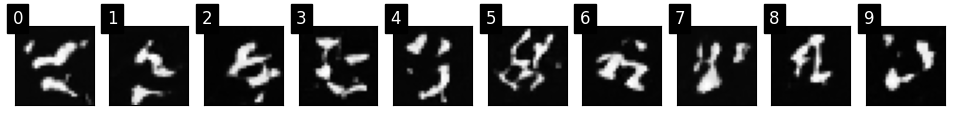

In [41]:
pics_rec= net.decoder(torch.distributions.Normal(0, 1).sample((10, 4, 7, 7)).to(device))
show_sample(list(pics_rec.squeeze(1).detach().cpu()), list(np.arange(10)))

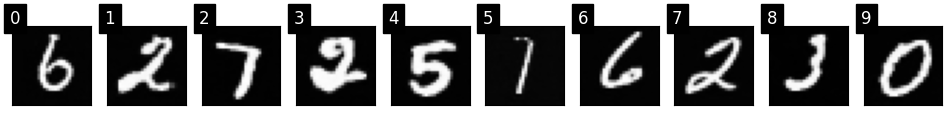

In [25]:
# show image
show_sample(pred[0: 10], list(np.arange(10)))

In [47]:
lr, device, unet_save_path, patience, epochs= 0.001, 'cuda:0', './u_net.pt', 20, 200
vae= torch.load(vae_save_path).to(device)
u_net= UNet().to(device)
dm= DenoiseDiffusion(u_net, 1000, device= device)
opt_dm= torch.optim.Adam(u_net.parameters(), lr= lr)

In [48]:
best_score, score, early_stop_time= 1e10, 0, 0
for epoch in range(epochs):
    loss_record= []
    for step, (pic, labels) in enumerate(train_loader):
        pic= pic.view(-1, 1, 28, 28).to(device)
        _, _, latent= vae.encoder(pic)
        loss= dm.loss(latent)
        opt_dm.zero_grad()
        loss_record.append(loss.item())
        loss.backward()
        opt_dm.step()
    print(f'training epoch: {epoch+ 1}, mean loss: {torch.tensor(loss_record).mean()}')
    loss_record= []
    with torch.no_grad():
        for step, (pic, labels) in enumerate(valid_loader):
            pic= pic.view(-1, 1, 28, 28).to(device)
            _, _, latent= vae.encoder(pic)
            loss= dm.loss(latent)
            loss_record.append(loss.item()) 
    mean_loss= torch.tensor(loss_record).mean()
    # early stopping
    if mean_loss< best_score:
        early_stop_time= 0
        best_score= mean_loss
        torch.save(u_net, f'{unet_save_path}')
    else:
        early_stop_time= early_stop_time+ 1
    if early_stop_time> patience:break
    # output
    print(f'early_stop_time/early_stop_threshold: {early_stop_time+ 1}/{patience}, mean loss: {mean_loss}')

training epoch: 1, mean loss: 0.37409156560897827
early_stop_time/early_stop_threshold: 0/20, mean loss: 0.23846836388111115
training epoch: 2, mean loss: 0.235971599817276
early_stop_time/early_stop_threshold: 0/20, mean loss: 0.22753453254699707
training epoch: 3, mean loss: 0.22824180126190186
early_stop_time/early_stop_threshold: 1/20, mean loss: 0.22973550856113434
training epoch: 4, mean loss: 0.22256916761398315
early_stop_time/early_stop_threshold: 0/20, mean loss: 0.2260705977678299
training epoch: 5, mean loss: 0.21958480775356293
early_stop_time/early_stop_threshold: 0/20, mean loss: 0.21683673560619354
training epoch: 6, mean loss: 0.22163589298725128
early_stop_time/early_stop_threshold: 0/20, mean loss: 0.21658693253993988
training epoch: 7, mean loss: 0.21940961480140686
early_stop_time/early_stop_threshold: 0/20, mean loss: 0.21378429234027863
training epoch: 8, mean loss: 0.2174241840839386
early_stop_time/early_stop_threshold: 1/20, mean loss: 0.2180473804473877
train

In [51]:
def show_sample2d(images, texts):   
    num_rows = len(images)
    num_cols = len(images[0]) if images else 0
    _, figs = plt.subplots(num_rows, num_cols, figsize=(12, 12))
    for i in range(num_rows):  
        for j in range(num_cols):  
            f, img, text= figs[i][j], images[i][j], texts[i][j]
            img = img.view(28, 28)
            f.imshow(img, cmap='gray')
            f.axis('off')
            f.text(0.5, 0.05, text, ha='center', va='center', fontsize=12,   
                   color='white', backgroundcolor='black', bbox=dict(facecolor='black', edgecolor='none', boxstyle='round'))  
    plt.subplots_adjust(wspace=0.24, hspace=-0.88)
    plt.show()

In [56]:
vae, u_net= torch.load(vae_save_path), torch.load(unet_save_path)
dm= DenoiseDiffusion(u_net, 1000, device= device)
from tqdm import tqdm
test_pic_num= 4
images, texts= [], []
for i in range(test_pic_num):
    images_, texts_= [], []
    print(f'sample {i+ 1} image, denoising...')
    xt= torch.randn((1, 4, 7, 7), device= device)
    for t in tqdm(reversed(range(1000))):
        xt_1= dm.p_sample(xt, torch.tensor([t]).to(device))
        xt= xt_1
        if (t+ 1)% 100== 1:
            denoising_pic= vae.decoder(xt)
            images_.append(denoising_pic.view(1, 28, 28).to('cpu').detach())
            texts_.append(t+ 1)
    images.append(images_)
    texts.append(texts_)

sample 1 image, denoising...


1000it [00:22, 44.89it/s]


sample 2 image, denoising...


1000it [00:22, 44.79it/s]


sample 3 image, denoising...


1000it [00:23, 43.37it/s]


sample 4 image, denoising...


1000it [00:22, 44.98it/s]


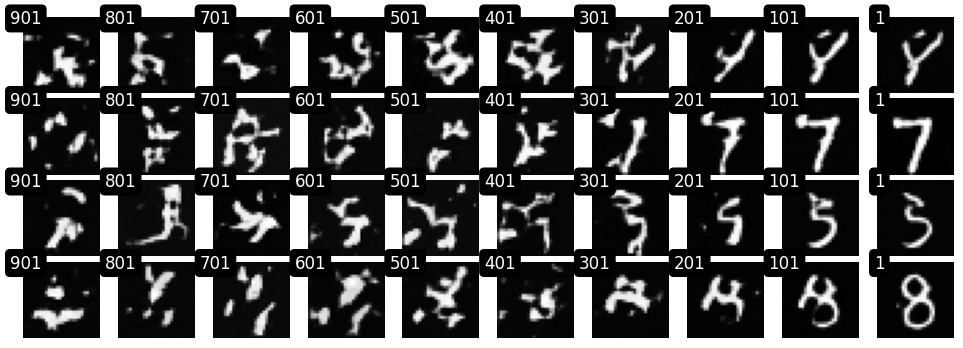

In [57]:
show_sample2d(images, texts)